# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Exercise-7.2.--One-versus-All-classification" data-toc-modified-id="Exercise-7.2.--One-versus-All-classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exercise 7.2.  One-versus-All classification</a></div><div class="lev1 toc-item"><a href="#Exercise-7.3.--Multi-class-Perceptron" data-toc-modified-id="Exercise-7.3.--Multi-class-Perceptron-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercise 7.3.  Multi-class Perceptron</a></div><div class="lev1 toc-item"><a href="#Exercise-7.5.-Multi-class-Softmax" data-toc-modified-id="Exercise-7.5.-Multi-class-Softmax-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercise 7.5. Multi-class Softmax</a></div><div class="lev1 toc-item"><a href="#Exercise-7.10.--Weighted-multi-class-Softmax" data-toc-modified-id="Exercise-7.10.--Weighted-multi-class-Softmax-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercise 7.10.  Weighted multi-class Softmax</a></div><div class="lev1 toc-item"><a href="#Exercise-7.11.--Recognizing-handwritten-digits" data-toc-modified-id="Exercise-7.11.--Recognizing-handwritten-digits-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exercise 7.11.  Recognizing handwritten digits</a></div>

In [44]:
# import autograd-wrapped numpy
import autograd.numpy as np

# datapath to data
datapath = '../mlrefined_datasets/superlearn_datasets/'

import autograd.numpy as np
from jax import grad, hessian
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import mpmath


mpmath.mp.dps = 50
jax.config.update("jax_enable_x64", True)

# datapath to data
datapath = '../mlrefined_datasets/superlearn_datasets/'



class LinearReg:

    def __init__(self, X, Y, w0):
        self.X = np.column_stack((np.ones(len(X.T)), X.T)).astype(np.float64)
        self.Y = Y.astype(np.float64)
        self.w0 = jnp.array(w0, dtype=jnp.float64)
        self.w, self.w_history, self.method, self.loss = None, None, None, None
        

    
    def linear_model(self, x, w):
        return jnp.dot(x, w.T)

    def RMS(self, w):
        return jnp.mean((self.linear_model(jnp.stack(self.X), w) - self.Y)**2)
        
    def MAD(self, w):
        return jnp.mean(abs(self.linear_model(jnp.stack(self.X), w) - self.Y))

    def set_function_loss(self, fun):
        if fun == "RMS":
            self.method, self.loss = self.RMS, self.RMS
        elif fun == "MAD":
            self.method, self.loss = self.MAD, self.MAD
        else:
            raise TypeError("Invalid loss function specified")

    @staticmethod
    def build_history_of_loss(i, fun_list, method_name):
            k = np.linspace(0, i, i+1)
            fun_arr = np.array(fun_list)
            plt.plot(k, fun_arr)
            plt.xlabel('k')
            plt.ylabel('g(k)')
            plt.title('График истории функции потерь')
            plt.text(0.5, 0.9, f'Метод: {method_name}', ha='center', va='center', transform=plt.gca().transAxes)
            plt.grid(True)
            plt.show()
    
    
    def Adam(self, d, iter, b1, b2, loss=False, decreased=False):
        '''
        Adaptive Moment estimation - ADAM
        '''
        
        gradient = grad(self.loss)
        w0 = jnp.array(self.w0, dtype=jnp.float64)
        w_history = [w0]
        fun_history = [float(self.loss(w0))]
        w = w0
        for i in range(iter):
            grad_eval = gradient(w)
            if i > 0:
                ds = b1*ds - (1 - b1)*grad_eval
                h = b2*h + (1 - b2)*jnp.square(grad_eval)
            else:
                ds = -grad_eval
                h = jnp.square(grad_eval)
            
            diff = d*ds/jnp.sqrt(h)
            if decreased:
                diff = diff*(1 / (i + 1))
            w = w + diff
            f = self.loss(w)
            f = float(f)
            w_history.append(w)
            fun_history.append(f)

        self.w = w
        self.w_history = w_history
    
        if loss:
            LinearReg.build_history_of_loss(iter, fun_history, "Adam")
    
        return {"min": (w, f), "weights_history": w_history, "cost_history": fun_history, "iters": iter}

    
    def RMSProp(self, d, iter, gamma, loss=False, decreased=False):
        """
        Root Mean Squared Error Propogation - RMSProp
        
        """
        self.method, fun = self.RMS, self.RMS
        gradient = grad(fun)
        w0 = jnp.array(self.w0)
        w_history = [w0]
        fun_history = [float(fun(w0))]
        w = w0
        for i in range(iter):
            grad_eval = gradient(w)
            if i > 0:
                h = gamma*h + (1 - gamma)*jnp.square(grad_eval)
            else:
                h = jnp.square(grad_eval)
            
            diff = d*grad_eval/jnp.sqrt(h)
            if decreased:
                diff = diff*(1 / (i + 1))
            w = w - diff
            f = fun(w)
            f = float(f)
            w_history.append(w)
            fun_history.append(f)

        self.w = w
        self.w_history = w_history
    
        if loss:
            LinearReg.build_history_of_loss(iter, fun_history, "RMSProp")
    
        return {"min": (w, f), "weights_history": w_history, "cost_history": fun_history, "iters": iter}

        

    def gradient_descent(self, d, iter, loss=False, decreased=False, contour=False):
        """
        classic gradient descent
        """
        
        gradient = grad(self.loss)
        w0 = jnp.array(self.w0, dtype=jnp.float64)
        w_history = [w0]
        fun_history = [float(self.loss(w0))]
        w = w0
        for i in range(iter):
            grad_eval = gradient(w)
            diff = d*grad_eval
            if decreased:
                diff = diff*(1 / (i + 1))
            w = w - diff
            f = self.loss(w)
            f = float(f)
            w_history.append(w)
            fun_history.append(f)

        self.w = w
        self.w_history = w_history
    
    
        def build_contour_graph(w_history, f):
            # Вычисление значений функции на сетке
            x = np.linspace(-10, 10, 100)
            y = np.linspace(-10, 10, 100)
            a, b = np.meshgrid(x, y)
            Z = np.zeros_like(a)
    
            for i in range(len(a)):
                for j in range(len(b)):
                    Z[i, j] = f([a[i, j], b[i, j]])
            
            # Построение контурного графика
            plt.figure()
            plt.contour(x, y, Z, levels=20)
            plt.plot([w[0] for w in w_history], [w[1] for w in w_history], '-o')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Contour plot')
            plt.show()
    
        if loss:
            LinearReg.build_history_of_loss(iter, fun_history, "classic_grad_desc")
    
        if contour:
           build_contour_graph(w_history, fun) 
    
        return {"min": (w, f), "weights_history": w_history, "cost_history": fun_history, "iters": iter}

    def Newton(self, iter, loss=False, contour=False, regular=0):
        """
        classic Newton method
        """
        
        gradient = grad(self.loss)
        w0 = jnp.array(self.w0, dtype=jnp.float64)
        w_history = [w0]
        fun_history = [float(self.loss(w0))]
        hess = hessian(self.loss)
        w = w0
        for i in range(iter):
            grad_eval = gradient(w)
            hess_eval = hess(w)
            b = jnp.dot(hess_eval + regular*jnp.eye(len(np.array(hess_eval))), w) - grad_eval
            w = jnp.linalg.solve(hess_eval, b)
            f = self.loss(w)
            f = float(f)
            w_history.append(w)
            fun_history.append(f)

        self.w = w
        self.w_history = w_history

        if loss:
            LinearReg.build_history_of_loss(iter, fun_history, "Newton_method")
    
        if contour:
           build_contour_graph(w_history, fun) 
    
        return {"min": (w, f), "weights_history": w_history, "cost_history": fun_history, "iters": iter}

    def normal_eq(self):
        self.w = jnp.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.Y
        self.w_history = [self.w0, self.w]
        self.method = self.RMS
        return self.w

    
    def predict(self, x):
        x = jnp.array(x)
        x = jnp.insert(x, 0, 1)
        weight = self.w0 if self.w is None else self.w
        return self.linear_model(x, weight)

    @property
    def metrics(self):
        weight = self.w0 if self.w is None else self.w
        return {"MSE": float(self.RMS(weight)), 
                "RMSE": float(jnp.sqrt(self.RMS(weight))), 
                "MAD": float(self.MAD(weight))}
    
    def _build_method_history(self):
        g = jnp.array(list(map(self.method, self.w_history)))
        plt.plot(jnp.array(self.w_history), g)
        plt.xlabel("w")
        plt.ylabel('g(w)')
        plt.title(f'История метода {self.method.__name__}')
        plt.show()


class LinearClass(LinearReg):
    
    def __init__(self, X, Y, w0, lamb=0):
        self.X = np.column_stack((np.ones(len(X.T)), X.T))
        self.Y = Y[0]
        self.w0 = jnp.array(w0)
        self.w, self.w_history, self.method = None, None, None
        self.lamb = lamb

    def sigma(self, arg):
        return 1 / (1 + jnp.exp(-arg))

    def RMS(self, w):
        return jnp.mean((self.sigma(self.linear_model(jnp.stack(self.X), w)) - self.Y)**2)

    def predict(self, x):
        x = jnp.array(x, dtype=jnp.float64)
        ones = jnp.ones((x.shape[0], 1), dtype=jnp.float64)
        conc = jnp.concatenate((ones, x), axis=1)
        weight = self.w0 if self.w is None else self.w
        calc_lin = self.linear_model(conc, weight)
        return jnp.where(jnp.unique(self.Y)[0], jnp.tanh(calc_lin), self.sigma(calc_lin)) if not self.loss.__name__ == "ReLU" else calc_lin

    def set_function_loss(self, fun):
        if fun == "RMS":
            self.method, self.loss = self.RMS, self.RMS
        elif fun == "MAD":
            self.method, self.loss = self.MAD, self.MAD
        elif fun == "Cross_entropy":
            self.method, self.loss = self.cross_entropy, self.cross_entropy
        elif fun == "soft_max_log":
            self.method, self.loss = self.soft_max_log, self.soft_max_log
        elif fun == "soft_max":
            self.method, self.loss = self.soft_max, self.soft_max
        elif fun == "ReLU":
            self.method, self.loss = self.ReLU, self.ReLU
        else:
            raise TypeError("Invalid loss function specified")

        return f"Current function of loss {fun}"

    def cross_entropy(self, w):
        eps = 1e-15
        ones_vector = jnp.ones_like(self.Y)
        eps_vector = eps*ones_vector
        left = self.Y*jnp.log(eps_vector + self.sigma(self.linear_model(jnp.stack(self.X), w)))  
        right = jnp.nan_to_num((ones_vector - self.Y)*jnp.log(eps_vector + ones_vector - self.sigma(self.linear_model(jnp.stack(self.X), w))), nan=-0.0) 
        return -jnp.mean(self.Y*left + right)

    def soft_max(self, w):
        ones_vector = jnp.ones_like(self.Y)
        log_terms = jnp.log(ones_vector + jnp.exp(-self.Y*self.linear_model(jnp.stack(self.X), w))) + self.lamb*jnp.linalg.norm(w)**2
        return jnp.mean(log_terms)

    def soft_max_log(self, w):
        positive_mask = self.Y > 0
        negative_mask = self.Y < 0
        positive_terms = -jnp.log(self.sigma(self.linear_model(self.X[positive_mask], w)))
        negative_terms = -jnp.log(1 - self.sigma(self.linear_model(self.X[negative_mask], w)))
        s = jnp.sum(positive_terms) + jnp.sum(negative_terms)
        return s / len(self.Y)

    def ReLU(self, w):
        lin_calc = self.linear_model(jnp.stack(self.X), w)
        term = -self.Y*lin_calc
        positive_mask = term > 0
        return jnp.sum(term[positive_mask]) / len(self.Y)

    
    def metrics(self, x):
        pr = self.predict(x)
        if self.loss.__name__ == "cross_entropy":
            pr[pr < 0.5] = 0
            pr[pr >= 0.5] = 1
        else:
            pr = jnp.sign(pr)

        res =  pr - self.Y
        incorrects = jnp.count_nonzero(res)
        accuracy = 1 - incorrects / len(self.Y)
        return f"incorr: {incorrects}\nacc: {accuracy}"



        
    



# Exercise 7.2.  One-versus-All classification

(2, 40)
(1, 40)


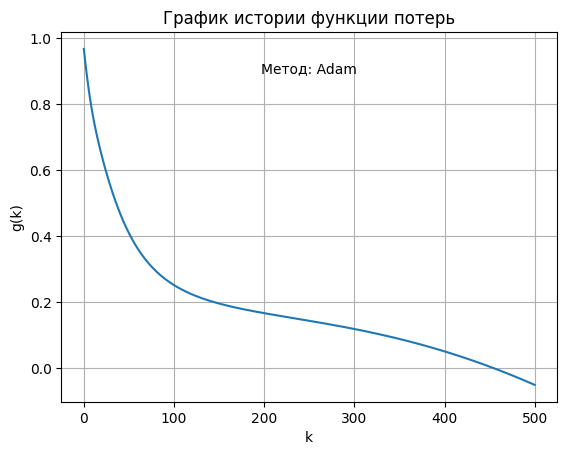

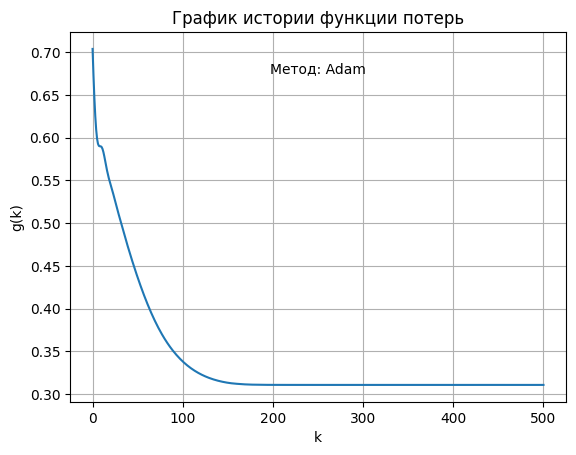

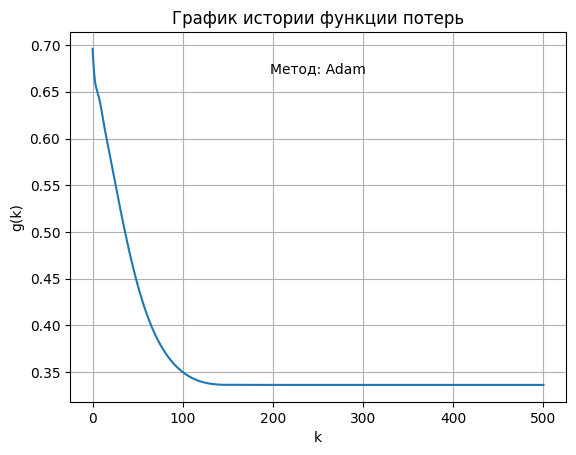

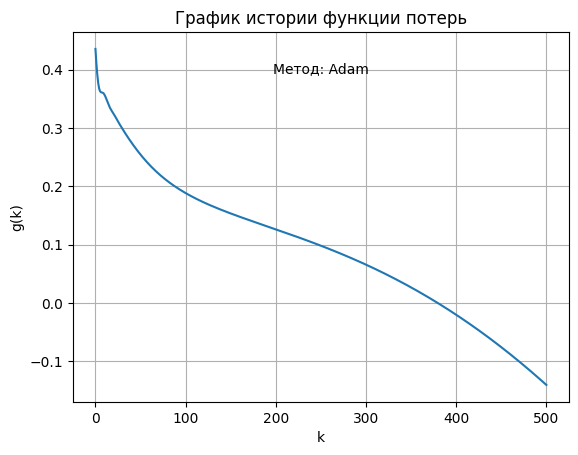

10


In [45]:
# load in dataset
csvname = datapath + '4class_data.csv'
data = np.loadtxt(csvname,delimiter = ',');

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:]





print(np.shape(x))
print(np.shape(y))

unique_labels = np.unique(y)
class_arrays = [np.where(y == label, 1, -1) for label in unique_labels]

buffer = []


for arr in class_arrays:
    clsficator = LinearClass(x, arr, [-2.5, 3.0, -2.5], lamb=-10e-5)
    clsficator.set_function_loss("soft_max")
    clsficator.Adam(0.1, 500, 0.8, 0.9, loss=True)
    y_pred = list(clsficator.predict(x.T))
    y_pred = list(map(float, y_pred))
    buffer.append(y_pred)
    
    


matrix = np.array(buffer).T
y_ova = np.argmax(matrix, axis=1)
mis = y_ova - y.flatten()
print(np.count_nonzero(mis))
    


    
    




# Exercise 7.3.  Multi-class Perceptron

[[0.14862  0.081797 0.20622  0.23157  0.33525  0.2477   0.1371   0.32373
  0.28226  0.18318  0.76613  0.68088  0.91359  0.79839  0.71544  0.58871
  0.71774  0.93894  0.77765  0.88134  0.4182   0.34217  0.4735   0.57949
  0.4159   0.52419  0.32834  0.25461  0.197    0.59332 ]
 [0.71574  0.62536  0.63703  0.86152  0.76822  0.78571  0.85569  0.65743
  0.55539  0.55539  0.89067  0.76531  0.68367  0.54665  0.54665  0.58746
  0.42128  0.55831  0.70991  0.76822  0.18222  0.27259  0.28717  0.053936
  0.021866 0.15889  0.16472  0.31341  0.20262  0.23178 ]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2.]]


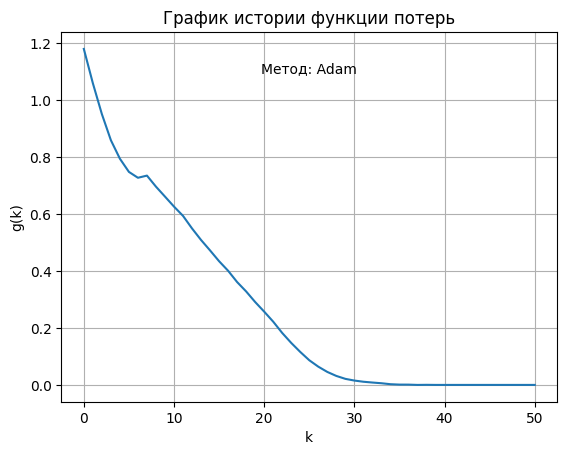

{'accuracy': Array(1., dtype=float32), 'balanced_accuracy': Array(1., dtype=float64)}


In [46]:
# load in dataset
data = np.loadtxt(datapath + '3class_data.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:]

print(x)
print(y)

class MultiClassification(LinearClass):
    def __init__(self, X, Y, w0, lamb=0):
        self.X = np.column_stack((np.ones(len(X.T)), X.T)).astype(np.float64)
        self.Y = Y.astype(np.float64).flatten()
        self.w0 = jnp.array(w0, dtype=jnp.float64)
        self.w, self.w_history, self.method, self.loss = None, None, None, None
        self.lamb = lamb
        

    def ReLU(self, w):
        lin_calc = self.linear_model(jnp.stack(self.X), w)
        max_term = jnp.max(lin_calc, axis=1)
        class_indices = jnp.arange(len(self.Y))
        lin_calc_indices = class_indices[self.Y.astype(int)]
        lin_calc_selected = lin_calc[class_indices, lin_calc_indices]
        result = max_term - lin_calc_selected
        return jnp.mean(result)

    def soft_max(self, w):
        lin_calc = self.linear_model(jnp.stack(self.X), w)
        left_term = jnp.log(jnp.sum(jnp.exp(lin_calc), axis=1))
        class_indices = jnp.arange(len(self.Y))
        lin_calc_indices = class_indices[self.Y.astype(int)]
        lin_calc_selected = lin_calc[class_indices, lin_calc_indices]
        result = left_term - lin_calc_selected
        return jnp.mean(result) + self.lamb*jnp.linalg.norm(w[1:, :], "fro")**2
        

    def predict(self, x):
        lin_calc = self.linear_model(jnp.stack(self.X), self.w)
        return jnp.argmax(lin_calc, axis=1)

    
    @property
    def metrics(self):
        predicted = self.predict(self.X)
        incorrect = jnp.count_nonzero(predicted - self.Y)
        accuracy = 1 - incorrect/jnp.size(self.Y)
        class_accs = []
        for label in jnp.unique(self.Y):
            it = jnp.array(jnp.where(self.Y == label))
            it_pr = jnp.array(jnp.where(predicted == label))
            inter = jnp.setxor1d(it, it_pr)
            class_accs.append(1 - jnp.size(inter) / jnp.size(it))
            
                
        balanced_acc = jnp.mean(jnp.array(class_accs)) 
        return {"accuracy": accuracy, "balanced_accuracy": balanced_acc}
        
        
        



mcp = MultiClassification(x, y, [[1.0, 2.0, -3.0], [1.0, 2.0, 1.0], [1.0, 1.0, 2.0]])
mcp.set_function_loss("ReLU")
mcp.Adam(0.1, 50, 0.8, 0.9, loss=True)
print(mcp.metrics)


        
        
    
    

# Exercise 7.5. Multi-class Softmax

[[0.12558  0.077189 0.17166  0.29608  0.3606   0.21313  0.45968  0.33295
  0.46889  0.21313  0.39055  0.52419  0.43894  0.58641  0.60945  0.70392
  0.73618  0.7523   0.68548  0.61175  0.2477   0.49885  0.37903  0.27765
  0.16014  0.14631  0.30991  0.42972  0.48733  0.53802  0.43664  0.66244
  0.77304  0.78917  0.65092  0.55876  0.5818   0.64862  0.74539  0.8606  ]
 [0.75948  0.6312   0.45627  0.60204  0.79446  0.86443  0.59329  0.47085
  0.80612  0.69534  0.6691   0.73615  0.47668  0.50583  0.64869  0.83528
  0.55539  0.70991  0.41837  0.8965   0.50875  0.52041  0.38921  0.31633
  0.34257  0.16472  0.15015  0.2551   0.39796  0.19971  0.12391  0.51458
  0.46793  0.27551  0.25802  0.39213  0.30466  0.12099  0.12974  0.37464 ]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]


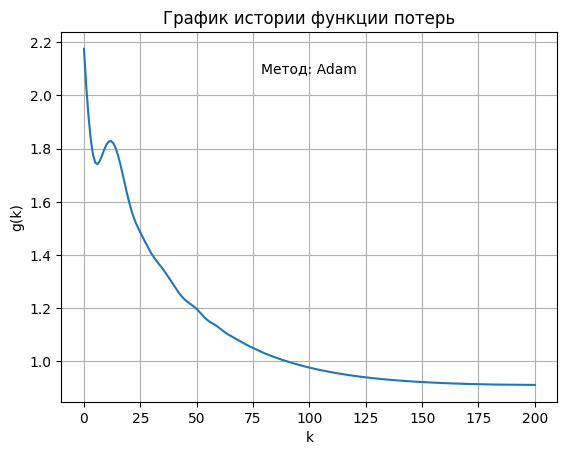

{'accuracy': Array(0.775, dtype=float32), 'balanced_accuracy': Array(0.55, dtype=float64)}
[[ -0.91365756 -15.12609766  12.25255858]
 [ -0.73575863   0.19649716   1.61155337]
 [  0.8723711   -1.34395945  -0.48604357]
 [ -0.14143096   1.16830742  -1.12793955]]


In [47]:
# load in dataset
data = np.loadtxt(datapath + '4class_data.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

print(x)
print(y)
mcp = MultiClassification(x, y, [[1.0, 2.0, -3.0], [1.0, 2.0, 1.0], [1.0, 1.0, 2.0], [1.0, 3.0, -4.0]], lamb=10e-3)
mcp.set_function_loss("soft_max")
mcp.Adam(0.1, 200, 0.9, 0.9, loss=True)
print(mcp.metrics)
print(mcp.w)


# Exercise 7.10.  Weighted multi-class Softmax

In [48]:
# weighted multiclass softmax
def multiclass_softmax(self,w,x,y,beta,iter):     
    # get subset of points
    x_p = x[:,iter]
    y_p = y[:,iter]
    beta_p = beta[:,iter]

    # pre-compute predictions on all points
    all_evals = model(x_p,w)

    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 0)) 

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y_p.astype(int).flatten(),np.arange(np.size(y_p))]
    cost = np.sum(beta_p*(a - b))

    # return average
    return cost/float(np.size(y_p))

# Exercise 7.11.  Recognizing handwritten digits

In [49]:
# get MNIST data from online repository
from sklearn.datasets import fetch_openml
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# convert string labels to integers
y = np.array([int(v) for v in y])[:,np.newaxis]

print(np.shape(x))
print(np.shape(y))




(70000, 784)
(70000, 1)


In [50]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


classifier = SGDClassifier(class_weight="balanced", eta0=10e+2, n_jobs=4, tol=10e-2, penalty="elasticnet", average=1000, loss="log_loss")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
classifier.fit(X_train, y_train.ravel())
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test.ravel(), y_pred)
cm = confusion_matrix(y_test.ravel(), y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix: ")
print(cm)

Accuracy: 0.9158857142857143
Confusion matrix: 
[[1716    1    2    0    6   10   18    2   15    2]
 [   0 1919    9    2    4    9    1    3   11    2]
 [  13   11 1518   20   34    8   26   22   51    4]
 [   8    9   41 1528    1   78    8   18   40   26]
 [   0    2    6    1 1617    7   12    1   10   52]
 [  21    6    5   35   21 1424   30    7   43   25]
 [   8    5   12    3    8   47 1629    0   11    0]
 [   4   10   19    4   18    2    2 1731    8   57]
 [  14   51    7   38   13   90   15   12 1449   27]
 [   7    7    4   16   70   17    1   54   12 1497]]


   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 991.0 kB/s eta 0:00:11
   ---------------------------------------- 0.1/10.6 MB 1.4 MB/s eta 0:00:08
   - -------------------------------------- 0.3/10.6 MB 2.5 MB/s eta 0:00:05
   -- ------------------------------------- 0.7/10.6 MB 4.0 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/10.6 MB 4.4 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/10.6 MB 4.4 MB/s eta 0:00:03
   ----- ---------------------------------- 1.5/10.6 MB 4.9 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/10.6 MB 4.8 MB/s eta 0:00:02
   -------- ------------------------------- 2.3/10.6 MB 5.6 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/10.6 MB 6.8 MB/s eta 0:00:02
   ------------- -------------------------- 3.5/10.6 MB 7.0 MB/s eta 0:00:02
   -------------- ------------------------- 3.9/10.6 MB 7.2 MB/s eta 0:00:01
   -

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orange3 3.36.1 requires scikit-learn<1.2.0,>=1.1.0, but you have scikit-learn 1.4.0 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\Alex\venv\Scripts\python.exe -m pip install --upgrade pip
